Saved:
  train.csv: data\test_8\train.csv
  test.csv : data\test_8\test.csv
train shape: (50000, 6) test shape: (150000, 7)
test y_type counts:
 y_type
0    70000
1    50000
2    30000
Name: count, dtype: int64


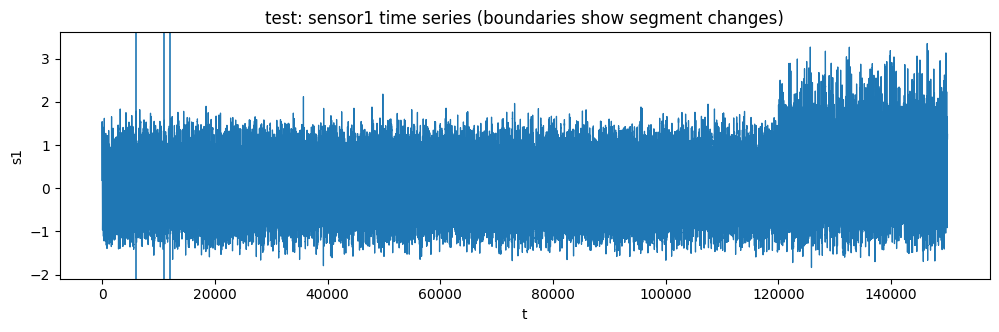

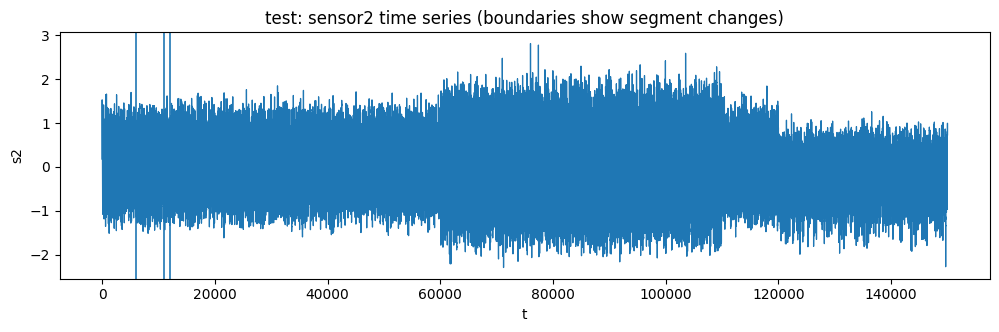

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# ============================================================
# 連続時系列版：MMD用 合成データ生成（2センサ）
# ・1サンプル = 時刻tの観測値
# ・列: t, s1, s2, y, y_type, (testはsegmentも)
# ・サイクル波形を「生成→連結」した後に、時系列全体へノイズを加える
# ・保存はCSVのみ（jsonは作らない）
# ============================================================

# ----------------------------
# 0) 波形の部品
# ----------------------------
def _sawtooth(theta):
    """ノコギリ波（[-1,1]、周期 2π）"""
    x = theta / (2 * np.pi)
    return 2 * (x - np.floor(x + 0.5))

def _gauss_bump(theta, mu, sigma):
    """周期境界をまたいでも自然につながる局所イベント（ガウス山）"""
    d = np.angle(np.exp(1j * (theta - mu)))  # 円周上の距離（-pi,pi]
    return np.exp(-0.5 * (d / sigma) ** 2)

def _base_cycle(theta, rng, base_complexity=1.0):
    """
    少し複雑めな「1サイクルの形」（ノイズ無し）
    - 基本正弦 + 高調波 + ノコギリ + 局所イベント(1〜2個)
    """
    phi1 = rng.uniform(-0.2, 0.2)
    phi2 = rng.uniform(-0.2, 0.2)
    phi3 = rng.uniform(-0.2, 0.2)

    a1 = rng.uniform(0.8, 1.2) * base_complexity
    a2 = rng.uniform(0.15, 0.35) * base_complexity
    a3 = rng.uniform(0.05, 0.20) * base_complexity
    b  = rng.uniform(0.05, 0.25) * base_complexity

    mu1  = rng.uniform(0.2 * np.pi, 1.8 * np.pi)
    sig1 = rng.uniform(0.06 * np.pi, 0.14 * np.pi)
    g1   = rng.uniform(0.15, 0.50) * base_complexity

    mu2  = rng.uniform(0.2 * np.pi, 1.8 * np.pi)
    sig2 = rng.uniform(0.05 * np.pi, 0.12 * np.pi)
    g2   = rng.uniform(0.00, 0.35) * base_complexity

    y = (
        a1 * np.sin(theta + phi1)
        + a2 * np.sin(2 * theta + phi2)
        + a3 * np.sin(3 * theta + phi3)
        + b  * _sawtooth(theta + rng.uniform(-0.1, 0.1))
        + g1 * _gauss_bump(theta, mu1, sig1)
        + g2 * _gauss_bump(theta, mu2, sig2)
    )
    y += rng.uniform(-0.2, 0.2) * base_complexity
    return y

# ----------------------------
# 1) 1サイクル（ノイズ無し）を2センサで生成
# ----------------------------
def make_clean_cycle_two_sensors(
    L, rng, mode=0, severity=None, normal_jitter=0.02, base_complexity=1.0
):
    """
    mode:
      0=正常
      1=異常1（位相ズレ+時間ゆがみ+センサ間結合変化）
      2=異常2（局所欠陥+スケール/オフセット変化）
    """
    if severity is None:
        severity = {}

    theta = np.linspace(0, 2 * np.pi, L, endpoint=False)

    # 正常のばらつき（位相揺らぎ + 軽い時間ゆがみ）
    shift = rng.normal(0.0, normal_jitter)
    warp_amp = rng.uniform(0.0, 0.03) * base_complexity
    warp_phi = rng.uniform(0, 2 * np.pi)
    theta_n = theta + shift + warp_amp * np.sin(theta + warp_phi)

    # センサ1
    s1 = _base_cycle(theta_n, rng, base_complexity=base_complexity)

    # センサ2（別形状 + 結合で相関）
    s2 = 0.75 * _base_cycle(theta_n + rng.uniform(-0.08, 0.08), rng, base_complexity=base_complexity)
    coupling = rng.uniform(0.10, 0.35)
    s2 = s2 + coupling * (s1 - np.mean(s1))

    if mode == 1:
        # 異常1：位相ズレ・ゆがみ・結合変化
        phase_shift     = severity.get("a1_phase_shift", 0.35)
        warp_boost      = severity.get("a1_warp_boost", 0.10)
        coupling_boost  = severity.get("a1_coupling_boost", 0.45)

        theta_a = theta + shift + phase_shift + (warp_amp + warp_boost) * np.sin(theta + warp_phi)
        s1 = _base_cycle(theta_a, rng, base_complexity=base_complexity)
        s2 = 0.75 * _base_cycle(theta_a + rng.uniform(-0.08, 0.08), rng, base_complexity=base_complexity)
        coupling_a = np.clip(coupling + coupling_boost, 0.0, 1.2)
        s2 = s2 + coupling_a * (s1 - np.mean(s1))

    elif mode == 2:
        # 異常2：局所欠陥 + スケール/オフセット
        defect_amp  = severity.get("a2_defect_amp", 1.10)
        defect_sig  = severity.get("a2_defect_sigma", 0.025)  # 周期比
        amp_scale1  = severity.get("a2_amp_scale1", 1.30)
        amp_scale2  = severity.get("a2_amp_scale2", 0.80)
        offset1     = severity.get("a2_offset1", 0.30)
        offset2     = severity.get("a2_offset2", -0.25)

        s1 = amp_scale1 * s1 + offset1
        s2 = amp_scale2 * s2 + offset2

        mu = rng.uniform(0, 2 * np.pi)
        sigma = defect_sig * 2 * np.pi
        bump = _gauss_bump(theta, mu, sigma)
        s1 = s1 + defect_amp * bump
        s2 = s2 - 0.6 * defect_amp * bump

    return s1.astype(np.float32), s2.astype(np.float32)

# ----------------------------
# 2) 連結後にノイズを加える（要求どおり）
# ----------------------------
def _ar1_noise(N, rng, sigma=0.05, rho=0.85):
    """AR(1)色付きノイズ"""
    e = rng.normal(0.0, sigma, size=N)
    y = np.empty(N, dtype=float)
    y[0] = e[0]
    for i in range(1, N):
        y[i] = rho * y[i - 1] + e[i]
    return y

def add_noise_after_concat(s, rng, sigma=0.05, rho=0.85):
    """連結後の時系列全体に色付きノイズを足す"""
    return (s.astype(float) + _ar1_noise(len(s), rng, sigma=sigma, rho=rho)).astype(np.float32)

# ----------------------------
# 3) 連続時系列データセット生成（CSV保存は train/test のみ）
# ----------------------------
def build_dataset_time_series_csv_only(
    L=256,
    N_train=5000,
    N_test=15000,
    test_segments=(6000, 5000, 1000, 3000),  # (正常, 異常1, 正常短, 異常2)
    seed=42,
    severity=None,
    base_complexity=1.0,
    normal_jitter=0.02,
    noise_sigma_s1=0.05,
    noise_sigma_s2=0.05,
    noise_rho_s1=0.85,
    noise_rho_s2=0.85,
    out_dir="/mnt/data/mmd_ts_nojson"
):
    if sum(test_segments) != N_test:
        raise ValueError(f"test_segments合計={sum(test_segments)} ですが N_test={N_test} です。合わせてください。")

    rng = np.random.default_rng(seed)
    out_path = Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)

    # ---- train（正常のみ）: サイクル生成→連結（ノイズ無し）
    train_s1_clean, train_s2_clean = [], []
    remaining = N_train
    while remaining > 0:
        c1, c2 = make_clean_cycle_two_sensors(L, rng, mode=0, severity=severity,
                                              normal_jitter=normal_jitter, base_complexity=base_complexity)
        take = min(L, remaining)
        train_s1_clean.append(c1[:take])
        train_s2_clean.append(c2[:take])
        remaining -= take

    train_s1_clean = np.concatenate(train_s1_clean)
    train_s2_clean = np.concatenate(train_s2_clean)

    # 連結後にノイズ
    train_s1 = add_noise_after_concat(train_s1_clean, rng, sigma=noise_sigma_s1, rho=noise_rho_s1)
    train_s2 = add_noise_after_concat(train_s2_clean, rng, sigma=noise_sigma_s2, rho=noise_rho_s2)

    df_train = pd.DataFrame({
        "t": np.arange(N_train, dtype=np.int32),
        "s1": train_s1,
        "s2": train_s2,
        "y": np.zeros(N_train, dtype=np.int16),
        "y_type": np.zeros(N_train, dtype=np.int16),
        "split": "train",
    })

    # ---- test: 区間ごとに mode を切り替えて「ノイズ無しで連結」
    seg_modes = [0, 1, 0, 2]
    seg_ids   = [0, 1, 2, 3]

    test_s1_clean, test_s2_clean = [], []
    y_type = np.empty(N_test, dtype=np.int16)
    segment = np.empty(N_test, dtype=np.int16)

    idx = 0
    for seg_len, mode, seg_id in zip(test_segments, seg_modes, seg_ids):
        remaining = seg_len
        while remaining > 0:
            c1, c2 = make_clean_cycle_two_sensors(L, rng, mode=mode, severity=severity,
                                                  normal_jitter=normal_jitter, base_complexity=base_complexity)
            take = min(L, remaining)
            test_s1_clean.append(c1[:take])
            test_s2_clean.append(c2[:take])
            y_type[idx:idx+take] = mode
            segment[idx:idx+take] = seg_id
            idx += take
            remaining -= take

    test_s1_clean = np.concatenate(test_s1_clean)
    test_s2_clean = np.concatenate(test_s2_clean)

    # 連結後にノイズ
    test_s1 = add_noise_after_concat(test_s1_clean, rng, sigma=noise_sigma_s1, rho=noise_rho_s1)
    test_s2 = add_noise_after_concat(test_s2_clean, rng, sigma=noise_sigma_s2, rho=noise_rho_s2)

    y = (y_type != 0).astype(np.int16)

    df_test = pd.DataFrame({
        "t": np.arange(N_test, dtype=np.int32),
        "s1": test_s1,
        "s2": test_s2,
        "y": y,
        "y_type": y_type,
        "segment": segment,
        "split": "test",
    })

    # ---- CSV保存（dfだけ）
    train_csv = out_path / "train.csv"
    test_csv  = out_path / "test.csv"
    df_train.to_csv(train_csv, index=False, float_format="%.6g")
    df_test.to_csv(test_csv, index=False, float_format="%.6g")

    return df_train, df_test, train_csv, test_csv


# ============================================================
# 4) 調整パラメータ（異常の形）
# ============================================================
SEVERITY = {
    # 異常1（位相ズレ/ゆがみ/結合変化）
    "a1_phase_shift": 0.35,      # rad
    "a1_warp_boost":  0.10,
    "a1_coupling_boost": 0.45,

    # 異常2（局所欠陥 + スケール/オフセット）
    "a2_defect_amp":   1.10,
    "a2_defect_sigma": 0.025,
    "a2_amp_scale1":   1.30,
    "a2_amp_scale2":   0.80,
    "a2_offset1":      0.30,
    "a2_offset2":     -0.25,
}

# ============================================================
# 5) 実行（生成 + CSV保存）
# ============================================================
df_train, df_test, train_csv, test_csv = build_dataset_time_series_csv_only(
    L=128,
    N_train=50000,
    N_test=150000,
    test_segments=(60000, 50000, 10000, 30000),
    seed=42,
    severity=SEVERITY,
    base_complexity=1.0,
    normal_jitter=0.02,
    noise_sigma_s1=0.05,
    noise_sigma_s2=0.05,
    noise_rho_s1=0.85,
    noise_rho_s2=0.85,
    out_dir=".\\data\\test_8"
)

print("Saved:")
print("  train.csv:", train_csv)
print("  test.csv :", test_csv)
print("train shape:", df_train.shape, "test shape:", df_test.shape)
print("test y_type counts:\n", df_test["y_type"].value_counts().sort_index())

# ============================================================
# 6) 可視化（1列=時系列をそのまま描く）
# ============================================================

N0, N1, N2, N3 = (6000, 5000, 1000, 3000)
b1 = N0
b2 = N0 + N1
b3 = N0 + N1 + N2

fig = plt.figure(figsize=(12, 3.2))
ax = fig.add_subplot(1,1,1)
ax.plot(df_test["t"].values, df_test["s1"].values, linewidth=0.9)
ax.axvline(b1, linewidth=1.2)
ax.axvline(b2, linewidth=1.2)
ax.axvline(b3, linewidth=1.2)
ax.set_title("test: sensor1 time series (boundaries show segment changes)")
ax.set_xlabel("t")
ax.set_ylabel("s1")

fig2 = plt.figure(figsize=(12, 3.2))
ax2 = fig2.add_subplot(1,1,1)
ax2.plot(df_test["t"].values, df_test["s2"].values, linewidth=0.9)
ax2.axvline(b1, linewidth=1.2)
ax2.axvline(b2, linewidth=1.2)
ax2.axvline(b3, linewidth=1.2)
ax2.set_title("test: sensor2 time series (boundaries show segment changes)")
ax2.set_xlabel("t")
ax2.set_ylabel("s2")

plt.show()

